<a href="https://colab.research.google.com/github/smf-9000/kaggle/blob/main/%5B002%5D_tabular_playground_series_jul_2021_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config Completer.use_jedi = False

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2021/train.csv
/kaggle/input/tabular-playground-series-jul-2021/test.csv


In [ ]:
submission_ex = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/test.csv')

targets_df = train_df[["target_carbon_monoxide","target_benzene","target_nitrogen_oxides"]].copy()
train_df.drop(["target_carbon_monoxide","target_benzene","target_nitrogen_oxides"], axis=1, inplace=True)  

In [ ]:
def root_mean_squared_log_error(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred)) 

In [ ]:
# train_df

In [ ]:
# test_df

In [ ]:
# targets_df

In [ ]:
# submission_ex.head()

In [ ]:
# train_df.describe()

In [ ]:
# test_df.describe()

In [ ]:
# train_df.isna().sum()

In [ ]:
# test_df.isna().sum()

### train dataset

In [ ]:
# ################################################################
# for c in train_df.columns:
#     if c != 'date_time':
#         fig = plt.figure(figsize = (15, 5))
#         g = train_df[c].plot()
#         g.legend([c])

In [ ]:
# ################################################################
# fig = plt.figure(figsize = (30,30))
# ax = fig.gca()
# hist = train_df[train_df.columns.values].hist(bins=150, ax = ax)

### test dataset

In [ ]:
# ################################################################
# for c in test_df.columns:
#     if c != 'date_time':
#         fig = plt.figure(figsize = (15, 5))
#         g = test_df[c].plot()
#         test_df['hmm'] = lowess(test_df[c].values, np.arange(len(test_df[c].values)), frac=0.15)[:, 1]
#         g = test_df['hmm'].plot()
#         g.legend([c])
# del test_df['hmm']

In [ ]:
# ################################################################
# fig = plt.figure(figsize = (30,30))
# ax = fig.gca()
# hist = test_df[test_df.columns.values].hist(bins=150, ax = ax)

### feature correlation

In [ ]:
# ################################################################
# corr = train_df.corr()
# fig = plt.figure(figsize = (15,15))
# sns.heatmap(corr, vmax = .8, square = True, annot=True)
# plt.show()

### new features

In [ ]:
# train_df['deg_K'] = (train_df['deg_C'] + 273.15)
# train_df['deg_x'] = (train_df['deg_K']**-0.1)
# train_df['s_3'] = (train_df['sensor_3']**-2)
# print(train_df.describe())
# train_df['sss_'] = (train_df['absolute_humidity'] / train_df['sensor_3'])
# train_df['sss_'] = ((train_df['sensor_5'])**-1)
# train_df['sss_'] = np.exp(train_df['absolute_humidity'].values)

In [ ]:
# fold_part = 1000

# a = train_df.iloc[1:fold_part,:].iloc[::-1]
# train_df = a.append(train_df)

# test_df = test_df.loc[1:]
# b = test_df.iloc[-fold_part:-1,:].iloc[::-1]
# test_df = test_df.append(b)

# df = train_df.append(test_df)
# df.reset_index(drop=True, inplace=True)

# -------------------------------------------------
for df in [train_df, test_df]:
    df['deg_K'] = (df['deg_C'] + 273.15)
    df['deg_x'] = (df['deg_K']**-0.1)
    df['s_3'] = (df['sensor_3']**-0.1)

    # for col in df.columns:
    #     print('col: ', col, '...')
    #     if col not in ['date_time']:
    #         for mean in [0.1]: # [0.03, 0.1, 0.2]
    #             m_v = lowess(df[col].values, np.arange(len(df[col].values)), frac=mean)[:, 1]
    #             df['mean_' + str(mean) + '_' + col] = m_v
    # #             df['mean_' + str(mean) + '_' + col + '_**2'] = m_v**1.3

    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

    df['time'] = df['date_time'].astype(np.int64)//10**9
    df['hh'] = df['date_time'].dt.hour.values
    df['day_of_w'] = df['date_time'].dt.dayofweek.values
    df['weekend'] = df['day_of_w'].apply(lambda x: 1 if (x>4)  else 0)
    df['saturday'] = df['day_of_w'].apply(lambda x: 1 if (x == 5)  else 0)
    df['sunday'] = df['day_of_w'].apply(lambda x: 1 if (x == 6)  else 0)
#     df['day_of_m'] = df['date_time'].dt.day.values
    df['month'] = df['date_time'].dt.month.values

    df["SMC"] = (df["absolute_humidity"] * 100) / df['relative_humidity']

    df['hm_1'] = ((df['absolute_humidity'].values < 0.25)).astype(int)

    # lag_features = ['deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
    # lags = [3, 6, 9, 12]
    # for feature in lag_features:
    #     for lag in lags:
    #         df[feature + '_lag_' + str(lag)] = df[feature].shift(periods=lag, fill_value = 0)

# -------------------------------------------------

# train_df = df.iloc[fold_part - 1:fold_part - 1 +  7111,:].copy()
# test_df = df.iloc[fold_part - 1 +  7111 - 1:-fold_part + 1,:].copy()
# train_df.reset_index(drop=True, inplace=True)
# test_df.reset_index(drop=True, inplace=True)

In [ ]:
# from sklearn import preprocessing
# # scaler = preprocessing.MinMaxScaler()
# # scaler = preprocessing.MaxAbsScaler()
# scaler = preprocessing.StandardScaler()
# for df in [train_df, test_df]:
#     for c in df.columns:
#         if c not in ['target_carbon_monoxide','target_benzene','target_nitrogen_oxides','date_time']:
#             df[[c]] = scaler.fit_transform(df[[c]])

In [ ]:
# test_df.head()

### GridSearch

In [ ]:
# lgbm = LGBMRegressor()
# _target = 'target_carbon_monoxide'
# X = np.array(train_df[list(test_df.columns.values)[1:]].values, dtype='float32')
# hm_indices = train_df[train_df['hm_1'] == 1].index.values
# X = np.delete(X, [e for e in hm_indices if e < 5500], axis=0)
# y = np.squeeze(np.array(targets_df[[_target]].values, dtype='float32'))
# y = np.delete(y, [e for e in hm_indices if e < 5500], axis=0)
# params = {
#     'num_leaves': [31],
#     'learning_rate': [0.01, 0.005, 0.001],
#     'max_depth': [4, 5, 6],
#     'n_estimators': [1500]
# }
# grid= GridSearchCV(estimator=lgbm, param_grid = params, cv = 3, n_jobs=-1, verbose=True)
# grid.fit(X, y)
# print('=====================================', 'target: ', _target)
# print(grid.best_estimator_)
# print('-------------------------------------')
# print(grid.best_score_)
# print('-------------------------------------')
# print(grid.best_params_)

In [ ]:
# lgbm = LGBMRegressor()
# _target = 'target_benzene'
# X = np.array(train_df[list(test_df.columns.values)[1:]].values, dtype='float32')
# y = np.squeeze(np.array(targets_df[[_target]].values, dtype='float32'))
# params = {
#     'num_leaves': [5, 7, 9],
#     'learning_rate': [0.03, 0.01, 0.003],
#     'max_depth': [2, 3, 4],
#     'n_estimators': [500, 700, 1000, 1500]
# }
# grid= GridSearchCV(estimator=lgbm, param_grid = params, cv = 3, n_jobs=-1, verbose=True)
# grid.fit(X, y)
# print('=====================================', 'target: ', _target)
# print(grid.best_estimator_)
# print('-------------------------------------')
# print(grid.best_score_)
# print('-------------------------------------')
# print(grid.best_params_)

In [ ]:
# lgbm = LGBMRegressor(reg_sqrt=True)
# _target = 'target_nitrogen_oxides'
# X = np.array(train_df[list(test_df.columns.values)[1:]].values, dtype='float32')
# hm_indices = train_df[train_df['hm_1'] == 1].index.values
# X = np.delete(X, [e for e in hm_indices if e < 5500], axis=0)
# y = np.squeeze(np.array(targets_df[[_target]].values, dtype='float32'))
# y = np.delete(y, [e for e in hm_indices if e < 5500], axis=0)
# params = {
#     'num_leaves': [2, 3, 4],
#     'learning_rate': [0.03, 0.01],
#     'max_depth': [-1],
#     'n_estimators': [500, 1000]
# }
# grid= GridSearchCV(estimator=lgbm, param_grid = params, cv = 3, n_jobs=-1, verbose=True)
# grid.fit(X, y)
# print('=====================================', 'target: ', _target)
# print(grid.best_estimator_)
# print('-------------------------------------')
# print(grid.best_score_)
# print('-------------------------------------')
# print(grid.best_params_)

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error

def rmsle(y, y_pred, **kwargs):
    out = np.sqrt(mean_squared_log_error(np.exp(y), np.exp(y_pred)))
    return out

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

### LGBMRegressor

In [ ]:
# ===================================== target:  target_carbon_monoxide
# LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1500)
# -------------------------------------
# 0.8743722910362125
# -------------------------------------
# {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1500, 'num_leaves': 31}

# ===================================== target:  target_nitrogen_oxides
# LGBMRegressor(learning_rate=0.03, n_estimators=500, num_leaves=3, reg_sqrt=True)
# -------------------------------------
# 0.554804521896887
# -------------------------------------
# {'learning_rate': 0.03, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 3}

In [ ]:
# ===================================== target:  target_carbon_monoxide
# LGBMRegressor(learning_rate=0.005, max_depth=7, n_estimators=2000,
#               num_leaves=21)
# -------------------------------------
# 0.8567034718216164
# -------------------------------------
# {'learning_rate': 0.005, 'max_depth': 7, 'n_estimators': 2000, 'num_leaves': 21}

# ===================================== target:  target_benzene
# LGBMRegressor(learning_rate=0.01, max_depth=2, n_estimators=1500, num_leaves=5)
# -------------------------------------
# 0.9679080634150427
# -------------------------------------
# {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1500, 'num_leaves': 5}

# ===================================== target:  target_nitrogen_oxides
# LGBMRegressor(n_estimators=300, num_leaves=5, reg_sqrt=True)
# -------------------------------------
# 0.7621435591250104
# -------------------------------------
# {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 5}

In [ ]:
# ===================================== target:  target_carbon_monoxide
# LGBMRegressor(learning_rate=0.01, max_depth=8, n_estimators=1600)
# -------------------------------------
# 0.8807068800145098
# -------------------------------------
# {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1600, 'num_leaves': 31}

# ===================================== target:  target_benzene
# LGBMRegressor(learning_rate=0.003, max_depth=4, n_estimators=1000, num_leaves=9)
# -------------------------------------
# 0.9652965873725134
# -------------------------------------
# {'learning_rate': 0.003, 'max_depth': 4, 'n_estimators': 1000, 'num_leaves': 9}

# ===================================== target:  target_nitrogen_oxides
# LGBMRegressor(learning_rate=0.05, n_estimators=500, num_leaves=4)
# -------------------------------------
# 0.7156610828094397
# -------------------------------------
# {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 4}

In [ ]:
# ===================================== target:  target_carbon_monoxide
# LGBMRegressor(learning_rate=0.005, max_depth=7, min_data_in_leaf=20,
#               n_estimators=1300, num_leaves=26)
# -------------------------------------
# 0.8820984830544785
# -------------------------------------
# {'learning_rate': 0.005, 'max_depth': 7, 'min_data_in_leaf': 20, 'n_estimators': 1300, 'num_leaves': 26}

# ===================================== target:  target_benzene
# LGBMRegressor(learning_rate=0.03, max_depth=3, n_estimators=700, num_leaves=7)
# -------------------------------------
# 0.9719938458962158
# -------------------------------------
# {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 700, 'num_leaves': 7}

# ===================================== target:  target_nitrogen_oxides
# LGBMRegressor(n_estimators=300, num_leaves=4)
# -------------------------------------
# 0.5840828704905612
# -------------------------------------
# {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 4}

In [ ]:
lgbm_regs = {}

lgbm_regs['target_carbon_monoxide'] = LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1500)

lgbm_regs['target_benzene'] = LGBMRegressor(learning_rate=0.01, max_depth=2, n_estimators=1500, num_leaves=5)

lgbm_regs['target_nitrogen_oxides'] = LGBMRegressor(learning_rate=0.03, n_estimators=500, num_leaves=3, reg_sqrt=True)

xgbr = XGBRegressor(objective = 'reg:squarederror')

### submission

In [ ]:
def postprocessing(pred, df):
    _hh = df['hh'].values
    _dow = df['day_of_w'].values
    _hm = df['hm_1'].values
    Mlr = {}
    Mrl = {}
    C = [0 for _ in range(len(pred))]
    D = [0 for _ in range(len(pred))]
    for i in range(len(pred)):
        j = len(pred) - 1 - i
        hl = _hh[i]
        dl = _dow[i]
        hml = _hm[i]
        hr = _hh[j]
        dr = _dow[j]
        hmr = _hm[j]
        curr_kl = str(hl)# + '_' + str(dl)
        curr_kr = str(hr)# + '_' + str(dr)
        if hml != 1:
            if curr_kl not in Mlr:
                Mlr[curr_kl] = []
            Mlr[curr_kl].append(pred[i])
        else:
            if curr_kl in Mlr:
                if len(Mlr[curr_kl]) > 1:
                    D[i] += sum(Mlr[curr_kl][-2:])
                    C[i] += 2
                    pass
                else:
                    D[i] += Mlr[curr_kl][0]
                    C[i] += 1
        if hmr != 1:
            if curr_kr not in Mrl:
                Mrl[curr_kr] = []
            Mrl[curr_kr].append(pred[j])
        else:
            if curr_kr in Mrl:
                if len(Mrl[curr_kr]) > 1:
                    D[j] += sum(Mrl[curr_kr][-2:])
                    C[j] += 2
                    pass
                else:
                    D[j] += Mrl[curr_kr][0]
                    C[j] += 1
    
#     print(C)
    for i in range(len(pred)):
        if C[i] != 0:
            pred[i] = D[i] / C[i]

In [ ]:
submit = True

submit:  target_carbon_monoxide
submit:  target_benzene
submit:  target_nitrogen_oxides


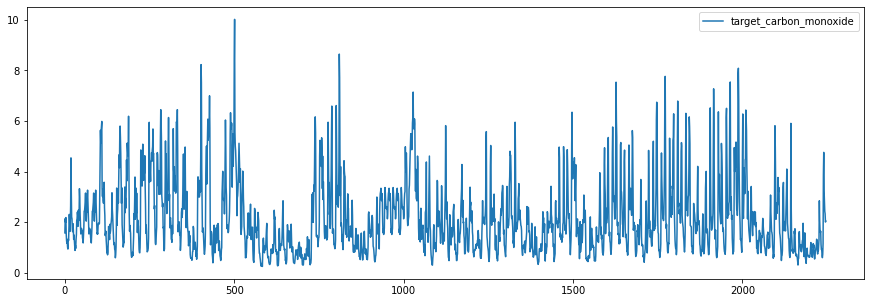

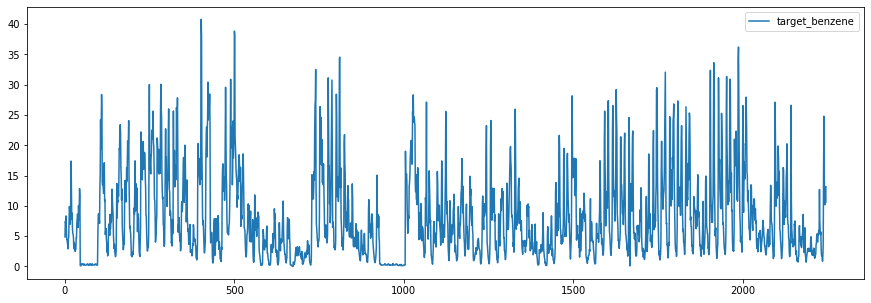

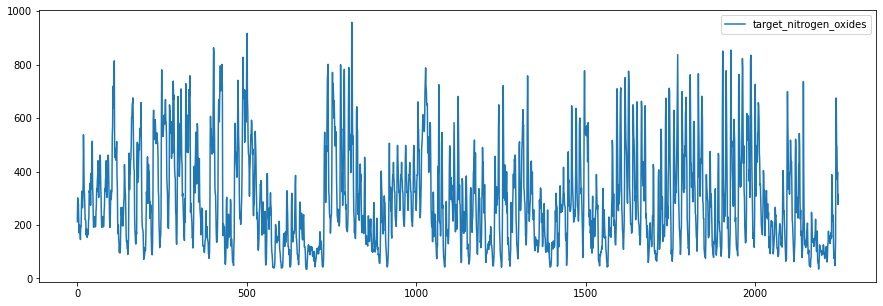

In [ ]:
submission = submission_ex.copy()


    
for _target in ['target_carbon_monoxide', 'target_benzene','target_nitrogen_oxides']:
    X = np.array(train_df[list(test_df.columns.values)[1:]].values, dtype='float32')
    hm_indices = train_df[train_df['hm_1'] == 1].index.values
    y = np.squeeze(np.array(targets_df[[_target]].values, dtype='float32'))
    X_test = np.array(test_df.iloc[:,1:].values, dtype='float32')
    
    if not submit:
        split_train = 3500
        X, X_val = X[:split_train], X[split_train:]
        y, y_val = y[:split_train], y[split_train:]
        
        if _target != 'target_benzene':
            X = np.delete(X, [e for e in hm_indices if e < split_train], axis=0)
            y = np.delete(y, [e for e in hm_indices if e < split_train], axis=0)
        
        lgbm_regs[_target].fit(X, y)
        p1 = lgbm_regs[_target].predict(X_val)
        
#         xgbr.fit(X, y)
#         p1 = xgbr.predict(X_val)
        
        if _target != 'target_benzene':
            postprocessing(p1, train_df.iloc[split_train:,:])
        
        print('target: ', _target)
        print('rmsle: ', root_mean_squared_log_error(y_val, p1))
        
        fig = plt.figure(figsize = (30, 15))
        g = targets_df.iloc[split_train:,:].reset_index()[_target].plot()
        tmp_col = pd.DataFrame(data=p1, columns=['tmp'])
        g = tmp_col['tmp'].plot(alpha = 0.7)
        
        g.legend([_target])
    else:
        print('submit: ', _target)
        
        if _target != 'target_benzene':
            X = np.delete(X, hm_indices, axis=0)
            y = np.delete(y, hm_indices, axis=0)
            
        lgbm_regs[_target].fit(X, y)
        p1 = lgbm_regs[_target].predict(X_test)
        
        if _target != 'target_benzene':
            postprocessing(p1, test_df)
            
        fig = plt.figure(figsize = (15, 5))
        tmp_col = pd.DataFrame(data=p1, columns=[_target])
        g = tmp_col[_target].plot()
        g.legend([_target])
            
        submission[_target] = p1


In [ ]:
submission.to_csv('submission.csv', index=False)

test = pd.read_csv('submission.csv')
test.tail()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
2242,2011-04-04 10:00:00,2.878033,12.828392,490.661428
2243,2011-04-04 11:00:00,2.434213,10.195796,370.692918
2244,2011-04-04 12:00:00,2.334877,12.518664,397.607420
2245,2011-04-04 13:00:00,2.007170,10.521508,276.630249
2246,2011-04-04 14:00:00,2.043334,13.149798,313.670408


In [ ]:
test.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.579021,4.885935,212.064596
1,2011-01-01 01:00:00,2.144785,7.447193,301.249383
2,2011-01-01 02:00:00,1.995932,7.141086,261.042131
3,2011-01-01 03:00:00,2.183672,8.346472,278.774035
4,2011-01-01 04:00:00,1.533286,6.478988,221.681497
